# Fine Tuning LLMs 
Fine-tuning large language models (LLMs) requires careful consideration of your dataset and the specific task at hand. Selecting the appropriate base model is a critical step in achieving optimal results.

In [3]:
# Importing necessary libraries
import pandas as pd
from openai import OpenAI
import os
from datasets import load_dataset
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
import json
import csv
import base64
import logging

SEED = 42
sns.set_style("whitegrid")
random.seed(SEED)

In [4]:
# Import the ClassLabel module to represent categorical class labels
from datasets import ClassLabel

# Load app reviews dataset's training into the 'dataset' variable
dataset = load_dataset("app_reviews", split="train")

# Converting the 'star' column in our dataset into a ClassLabel type
dataset = dataset.class_encode_column("star")

# Display the dataset to view the changes
dataset

Using the latest cached version of the dataset since app_reviews couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at C:\Users\anita\.cache\huggingface\datasets\app_reviews\default\0.0.0\9eaa95f66364367e8752b0f34c00f67aafa95d15 (last modified on Wed Apr 16 15:06:11 2025).


Dataset({
    features: ['package_name', 'review', 'date', 'star'],
    num_rows: 288065
})

In [5]:
dataset[0]

{'package_name': 'com.mantz_it.rfanalyzer',
 'review': "Great app! The new version now works on my Bravia Android TV which is great as it's right by my rooftop aerial cable. The scan feature would be useful...any ETA on when this will be available? Also the option to import a list of bookmarks e.g. from a simple properties file would be useful.",
 'date': 'October 12 2016',
 'star': 3}

In [6]:
# Splitting the dataset into training and testing sets
# We reserve 20% of the data for testing and use stratification
# on the 'star' column to ensure that the distribution of classes is similar in both sets
dataset = dataset.train_test_split(test_size = 0.2, stratify_by_column = "star")

# Now, we further split the training dataset to reserve 25% of it for its validation.
# Again, we stratify by the 'star' column to keep the distribution consistent
df = dataset['train'].train_test_split(test_size = 0.25, stratify_by_column = "star")

# Assigning the split datasets to their respective keys:
dataset['train'] = df['train']
dataset['val'] = df['test']

# Display the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 172839
    })
    test: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
    val: Dataset({
        features: ['package_name', 'review', 'date', 'star'],
        num_rows: 57613
    })
})

In [7]:
# convert to pandas DataFrame
training_df = pd.DataFrame(dataset['train'])

# Display the first few rows of the DataFrame
training_df[['review', 'star']].head(10)

,review,star
0,Boho pin. Many merits Very good app. Chathurar...,4
1,Not working on my samsung duos phone really ba...,4
2,I loved it,4
3,I really luv this app,4
4,Bakwas root require,0
5,Almost perfect Request: support for Nexonia. G...,3
6,This app is being so damn annoying!!!!,0
7,Bright star Best,4
8,Good one,2
9,Super,2


Text(0.5, 1.0, 'Distribution of Star Ratings in Training Set')

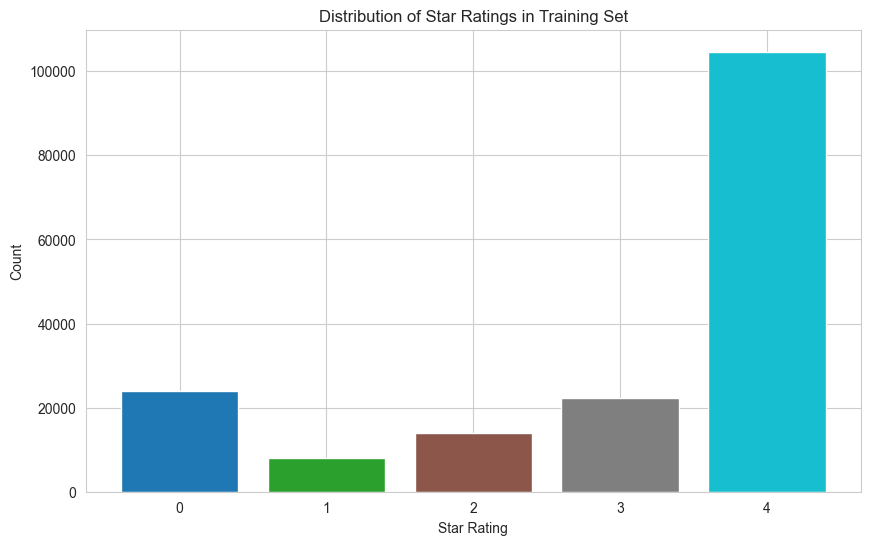

In [8]:
# Count the number of occurrences for each 'star' value, sorting by index
star_counts = training_df['star'].value_counts().sort_index()

# Create a barplot with different colors for each star
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(star_counts.index)))  # Generate a colormap
plt.bar(star_counts.index, star_counts.values, color=colors)
plt.xlabel('Star Rating')
plt.ylabel('Count')
plt.title('Distribution of Star Ratings in Training Set')


In [9]:
test_df = pd.DataFrame(dataset['test'])
val_df = pd.DataFrame(dataset['val'])

## Star Prediction (Sentiment)

In [10]:
"""
Prepare the 'review' and 'star' columns for OpenAI API in JSON format.

- The 'review' column is transformed into a 'prompt' by appending a separator ("###") at the end of each review.
- The 'star' column is converted into a string and stored as 'completion'.
- This data preparation is specifically designed for non-chat-based OpenAI models like the Babbage model,
(deprecated now) which is not a chat-based model.

The processed data is then saved into JSON files for training, validation, and testing datasets:
1. Duplicates are removed based on the 'prompt' column.
2. The data is shuffled randomly to ensure a diverse distribution.
3. Only the 'prompt' and 'completion' columns are retained in the output files.

Output Files:
- "app-review-full-train-sentiment-random.json" for the training dataset.
- "app-review-full-val-sentiment-random.json" for the validation dataset.
- "app-review-full-test-sentiment-random.json" for the testing dataset.
"""

# Lets convert the 'review' column to the 'prompt' adding the separator
training_df['prompt'] = training_df['review'] + "\n###\n"
val_df['prompt'] = val_df['review'] + "\n###\n"
test_df['prompt'] = test_df['review'] + "\n###\n"

# Lets convert the 'star' column to the 'completion' as a string
training_df['completion'] = training_df['star'].astype(str)
val_df['completion'] = val_df['star'].astype(str)   
test_df['completion'] = test_df['star'].astype(str)

# Store the training dataset in a JSON file format after dropping
# the duplicates, random shuffle to ensure data is reshuffled
training_df.sample(
        len(training_df)).drop_duplicates(
        subset = ['prompt']
        )[['prompt', 'completion']].to_json(
        "app-review-full-train-sentiment-random.jsonl",
        orient = "records", lines = True
)

# Store the validation dataset in a JSON file format after dropping
# the duplicates, random shuffle to ensure data is reshuffled
val_df.sample(
        len(val_df)).drop_duplicates(
        subset = ['prompt']
        )[['prompt', 'completion']].to_json(
        "app-review-full-val-sentiment-random.jsonl",
        orient = "records", lines = True
)

# Store the test dataset in a JSON file format after dropping
# the duplicates, random shuffle to ensure data is reshuffled
test_df.sample(
        len(test_df)).drop_duplicates(
        subset = ['prompt']
        )[['prompt', 'completion']].to_json(
        "app-review-full-test-sentiment-random.jsonl",
        orient = "records", lines = True
)

In [11]:
"""
Prepare the data for Chat-based OpenAI GPT-3.5 models.

The format for each entry is as follows:
{
    'messages': [
        {'role': 'system', 'content': 'App review prediction'},
        {'role': 'user', 'content': 'Great App!'},
        {'role': 'assistant', 'content': '4'}
    ]
}
"""

# Function to prepare the data in the required format
def prepare_chat_data(df, system=''):
    return df.apply(
        lambda row: {
            'messages': [
                {'role': 'system', 'content': system},
                {'role': 'user', 'content': row['review']},
                {'role': 'assistant', 'content': str(row['star'])}
            ]
        },
        axis=1
    ).tolist()  # Convert the result to a list

# Prepare the training, validation, and test datasets
training_chat_data = prepare_chat_data(training_df)
val_chat_data = prepare_chat_data(val_df)
test_chat_data = prepare_chat_data(test_df)

# Save the prepared data to JSONL files
with open("app-review-full-train-sentiment-random3.5.jsonl", "w") as train_file:
    for entry in training_chat_data:
        train_file.write(json.dumps(entry) + "\n")

with open("app-review-full-test-sentiment-random3.5.jsonl", "w") as val_file:
    for entry in val_chat_data:
        val_file.write(json.dumps(entry) + "\n")

with open("app-review-full-val-sentiment-random3.5.jsonl", "w") as test_file:
    for entry in test_chat_data:
        test_file.write(json.dumps(entry) + "\n")


In [12]:
system_prompt = 'You predict star ratings from 0-4 where 0 is the worst rating and 4 is the best rating. \
 You are given a review and you need to predict the star rating.'

# Prepare the training, validation, and test datasets
training_chat_data_system = prepare_chat_data(training_df, system = system_prompt)
val_chat_data_system = prepare_chat_data(val_df, system = system_prompt)
test_chat_data_system = prepare_chat_data(test_df, system = system_prompt)

# Save the prepared data to JSONL files
with open("app-review-full-train-sentiment-random3.5-system.jsonl", "w") as train_file:
    for entry in training_chat_data_system:
        train_file.write(json.dumps(entry) + "\n")

with open("app-review-full-test-sentiment-random3.5-system.jsonl", "w") as val_file:
    for entry in val_chat_data_system:
        val_file.write(json.dumps(entry) + "\n")

with open("app-review-full-val-sentiment-random3.5-system.jsonl", "w") as test_file:
    for entry in test_chat_data_system:
        test_file.write(json.dumps(entry) + "\n")


In [13]:
# Test example
prepare_chat_data(pd.DataFrame({'review': ['Great App!'], 'star': [4]}), system = 'You predict stars')

[{'messages': [{'role': 'system', 'content': 'You predict stars'},
   {'role': 'user', 'content': 'Great App!'},
   {'role': 'assistant', 'content': '4'}]}]

# Using OpenAI's Fine-tuning API

In [17]:
# Reminder of what this data looks like
json.loads(open(r"app-review-full-train-sentiment-random.jsonl", "r").readlines()[0])

{'prompt': 'Useful app\n###\n', 'completion': '3'}

In [16]:
# Lets create an OpenAI API client instance
openai_api_key = os.getenv("OPENAI_API_KEY")
if openai_api_key is None:
    raise ValueError("Please set the OPENAI_API_KEY environment variable.")
client = OpenAI(api_key=openai_api_key) 
client    


## Babbage-002 FineTuning (Deprecated)

In [18]:
# Create a file object for the training dataset with OpenAI API
# whrere the purpose is set to 'fine-tune' with the training dataset
no_system_training_file = client.files.create(
    file = open("app-review-full-train-sentiment-random.jsonl", "rb"),
    purpose="fine-tune"
)

# Creating a file object for the validation dataset with OpenAI API
no_system_val_file = client.files.create(
    file = open("app-review-full-val-sentiment-random.jsonl", "rb"),
    purpose = "fine-tune"
)

In [19]:
no_system_training_file

FileObject(id='file-FxZqzFpa1i8dJaJVAzpyic', bytes=16038278, created_at=1744835988, filename='app-review-full-train-sentiment-random.jsonl', object='file', purpose='fine-tune', status='processed', expires_at=None, status_details=None)

In [ ]:
"""
Initialize the fine-tuning job using the OpenAI API.

This function sets up a fine-tuning job with the following parameters:
- `training_file`: The ID of the training file created earlier.
- `validation_file`: The ID of the validation file created earlier for evaluation purposes.
- `model`: The base model to fine-tune (e.g., "babbage-002").
- `hyperparameters`: A dictionary containing additional parameters for fine-tuning, such as batch size and learning rate.

The `client.fine_tuning.jobs.create` method is used to create the fine-tuning job. Babbagae is deprecated now.
"""

no_system_babbage_job = client.fine_tuning.jobs.create(
    training_file = no_system_training_file.id,
    validation_file = no_system_val_file.id,
    model = "babbage-002",
    hyperparameters = {
        "n_epochs": 1        
    }
)

# Retrieving details of an ongoing or completed fine-tuning job using OpenAI's API.
# The job ID is passed to the method, and it returns the job details.
# This can be used to monitor the status of the fine-tuning process, including its progress
#  and any errors that may have occurred.
job = client.fine_tuning.jobs.retrieve(no_system_babbage_job.id)

## GPT-3.5 FineTuning

In [34]:
json.loads(open(r"app-review-full-train-sentiment-random3.5.jsonl", "r").readlines()[0])

{'messages': [{'role': 'system', 'content': ''},
  {'role': 'user',
   'content': "Droid Turbo 2 and/or Marshmallow OS issues Long story short  I am very sad to say that with my Droid Turbo 1 on Lollipop dying and now I am on the DT2 with a fresh  clean install of Marshmallow  every other app is fine  but this one doesn't work. Every single phone and app setting is properly tweaked. It will NOT turn on and off based on cell phone tower triangulation. This app has not been updated since Jan. 2016 and it is June 2016. The technology is not playing nice. If this continues I must abandon the app and use another. Please fix guys!!!"},
  {'role': 'assistant', 'content': '0'}]}

In [35]:
# Create a file object for the training dataset with OpenAI API
# whrere the purpose is set to 'fine-tune' with the training dataset
no_system_training_file_3_5 = client.files.create(
    file = open("app-review-full-train-sentiment-random3.5.jsonl", "rb"),
    purpose="fine-tune"
)

# Creating a file object for the validation dataset with OpenAI API
no_system_val_file_3_5 = client.files.create(
    file = open("app-review-full-val-sentiment-random3.5.jsonl", "rb"),
    purpose = "fine-tune"
)

In [36]:
gpt_3_5_no_system_job = client.fine_tuning.jobs.create(
    training_file = no_system_training_file_3_5.id,
    validation_file = no_system_val_file_3_5.id,
    model = "gpt-3.5-turbo",
    hyperparameters = {
        "n_epochs": 1        
    }
)

In [37]:
gpt_3_5_no_system_job.id

'ftjob-gREuZJo8ibpLkItbc13IekKj'

In [38]:
for event in client.fine_tuning.jobs.list_events(fine_tuning_job_id=gpt_3_5_no_system_job.id):
    print(event, end = '\n--------\n')

FineTuningJobEvent(id='ftevent-UBObIy63MRr6VL6jjId7W5mP', created_at=1744838742, level='info', message='Validating training file: file-LbyrtpxATd1YYwTuaUtNk5 and validation file: file-8bejTS4zZa9s3TPRPubaxA', object='fine_tuning.job.event', data={}, type='message')
--------
FineTuningJobEvent(id='ftevent-A1beGcKGIoKSJ6lOGKerFRC7', created_at=1744838742, level='info', message='Created fine-tuning job: ftjob-gREuZJo8ibpLkItbc13IekKj', object='fine_tuning.job.event', data={}, type='message')
--------


In [ ]:
import time

job = client.fine_tuning.jobs.retrieve(gpt_3_5_no_system_job.id)

# Wait for the fine-tuning job to complete
while job.status not in ["succeeded", "failed"]:
    print(f"Job status: {job.status}. Waiting for completion...")
    time.sleep(90)  # Wait for 90 seconds before checking again
    job = client.fine_tuning.jobs.retrieve(gpt_3_5_no_system_job.id)

if job.status == "succeeded" and len(job.result_files):
    print("Fine-tuning job completed successfully!")
    print(job.result_files)
    results = client.files.content(job.result_files[0])

elif job.status == "failed":
    raise ValueError(f"Fine-tuning job failed with error: {job.error.message}")
else:
    raise ValueError("Unexpected job status!")

Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for completion...
Job status: validating_files. Waiting for comple

In [ ]:
# The ID of your result file that you already have
result_file_id = 'file-CddywJSudVjutJsiXhsBMJ'

# Download the content of the result file
results = client.files.content(result_file_id)
base64_string = results.read()

# Decode the base64 string
try:
    # Some OpenAI files are base64 encoded
    decoded_bytes = base64.b64decode(base64_string)
    decoded_str = decoded_bytes.decode('utf-8')
except:
    # If it's not base64 encoded, use the raw content
    decoded_str = base64_string.decode('utf-8')

# Save to a CSV file
with open("fine_tuning_results.csv", "w") as f:
    f.write(decoded_str)

# Create the dataframe
result_df = pd.read_csv("fine_tuning_results.csv")

# Now you can work with the dataframe, if you notice
# it calcuates accuracy since it recognizes its a classification task
# The validation loss does not get computed often because it would take
# a lot of time to compute it.
print(f"DataFrame shape: {result_df.shape}")
print(result_df.head())

DataFrame shape: (1503, 7)
   step  train_loss  train_accuracy  valid_loss  valid_mean_token_accuracy  \
0     1    11.11535         0.35942         NaN                        NaN   
1     2    11.15301         0.35942         NaN                        NaN   
2     3    11.17708         0.36522         NaN                        NaN   
3     4    11.43135         0.34493         NaN                        NaN   
4     5    11.01843         0.36232         NaN                        NaN   

   train_mean_reward  full_validation_mean_reward  
0                NaN                          NaN  
1                NaN                          NaN  
2                NaN                          NaN  
3                NaN                          NaN  
4                NaN                          NaN  


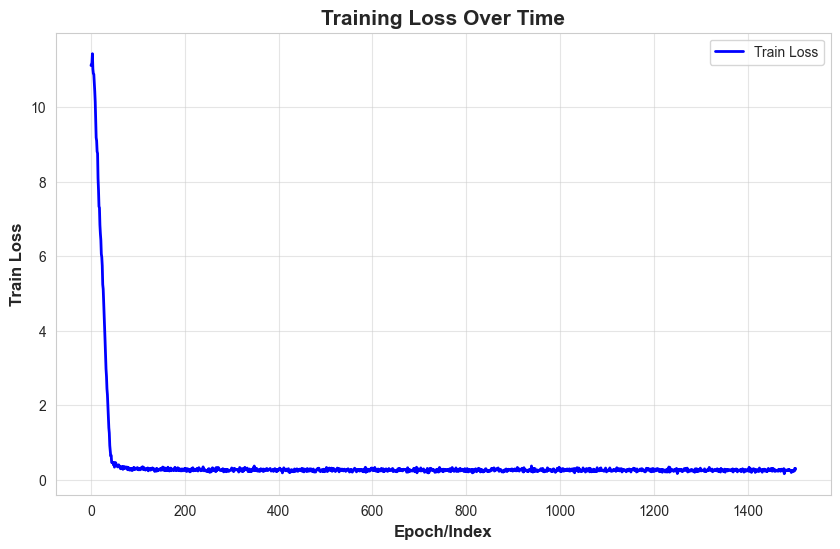

In [44]:
plt.figure(figsize=(10, 6))
result_df['train_loss'].dropna().plot(label='Train Loss', color='blue', linewidth=2)

# Adding labels and title
plt.xlabel('Epoch/Index', fontsize=12, fontweight='bold')
plt.ylabel('Train Loss', fontsize=12, fontweight='bold')
plt.title('Training Loss Over Time', fontsize=15, fontweight='bold')

# Adding a legend
plt.legend(fontsize=10)

# Display the grid for better readability
plt.grid(alpha=0.5)

# Show the plot
plt.show()


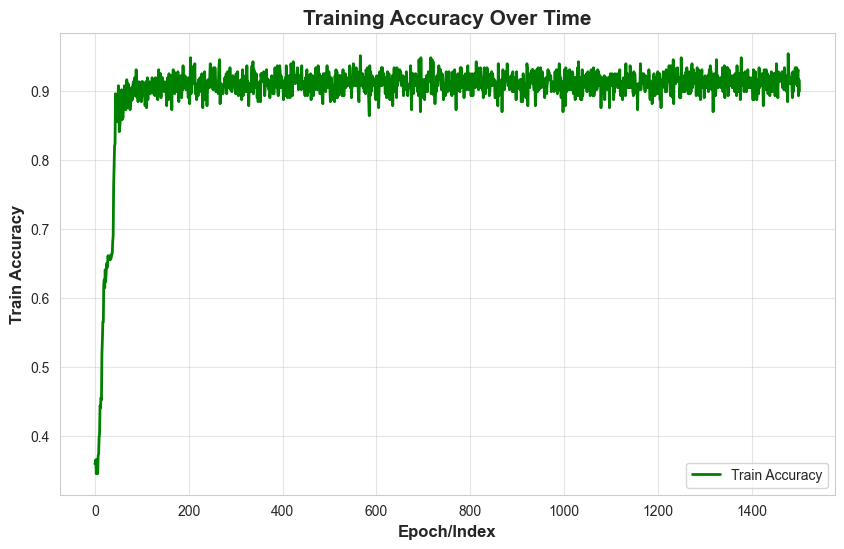

In [ ]:
plt.figure(figsize=(10, 6))
result_df['train_accuracy'].dropna().plot(label='Train Accuracy', color='green', linewidth=2)

# Adding labels and title
plt.xlabel('Epoch/Index', fontsize=12, fontweight='bold')
plt.ylabel('Train Accuracy', fontsize=12, fontweight='bold')
plt.title('Training Accuracy Over Time', fontsize=15, fontweight='bold')

# Adding a legend
plt.legend(fontsize=10)

# Display the grid for better readability
plt.grid(alpha=0.5)

# Show the plot
plt.show()


## Lets fine tune the resulting fine-tuned model above for 3 more epochs

In [46]:
job.fine_tuned_model

'ft:gpt-3.5-turbo-0125:personal::BN758GiZ'

In [ ]:
gpt_3_5_no_system_job_more_epochs = client.fine_tuning.jobs.create(
    training_file = no_system_training_file_3_5.id,
    validation_file = no_system_val_file_3_5.id,
    model = job.fine_tuned_model, # we use fine-tuned model
    hyperparameters = {
        "n_epochs": 3        
    }
)

# and follow the same process as above to check the status of the job

## Fine tune GPT-3.5 with a system prompt

In [14]:
# reminder of what this data looks like
json.loads(open(r"app-review-full-train-sentiment-random3.5-system.jsonl", "r").readlines()[0])

{'messages': [{'role': 'system',
   'content': 'You predict star ratings from 0-4 where 0 is the worst rating and 4 is the best rating.  You are given a review and you need to predict the star rating.'},
  {'role': 'user',
   'content': 'Boho pin. Many merits Very good app. Chathurarya sathya awabodhayata hethu weva.'},
  {'role': 'assistant', 'content': '4'}]}

In [17]:
training_file_3_5_system = client.files.create(
    file = open("app-review-full-train-sentiment-random3.5-system.jsonl", "rb"),
    purpose = "fine-tune"
)

val_file_3_5_system = client.files.create(
    file = open("app-review-full-val-sentiment-random3.5-system.jsonl", "rb"),
    purpose = "fine-tune"
)

In [18]:
gpt_3_5_system_job = client.fine_tuning.jobs.create(
    training_file = training_file_3_5_system.id,
    validation_file = val_file_3_5_system.id,
    model = "gpt-3.5-turbo", # use base model for new fine-tuning
    hyperparameters = {
        "n_epochs": 1       
    }
)

BadRequestError: Error code: 400 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details.', 'type': 'invalid_request_error', 'param': None, 'code': 'exceeded_quota'}}

In [51]:
gpt_3_5_system_job.id

NameError: name 'gpt_3_5_system_job' is not defined

In [53]:
job = client.fine_tuning.jobs.retrieve(gpt_3_5_system_job.id)

# Wait for the fine-tuning job to complete
while job.status not in ["succeeded", "failed"]:
    print(f"Job status: {job.status}. Waiting for completion...")
    time.sleep(90)  # Wait for 90 seconds before checking again
    job = client.fine_tuning.jobs.retrieve(gpt_3_5_system_job.id)

if job.status == "succeeded" and len(job.result_files):
    print("Fine-tuning job completed successfully!")
    print(job.result_files)
    results = client.files.content(job.result_files[0])

elif job.status == "failed":
    raise ValueError(f"Fine-tuning job failed with error: {job.error.message}")
else:
    raise ValueError("Unexpected job status!")

NameError: name 'gpt_3_5_system_job' is not defined

In [ ]:
# The ID of your result file from the GPT-3.5 system fine-tuning job
result_file_id = job.result_files[0]  # Get the result file ID from the current job

# Download the content of the result file
results = client.files.content(result_file_id)
base64_string = results.read()

# Decode the base64 string
try:
    # Some OpenAI files are base64 encoded
    decoded_bytes = base64.b64decode(base64_string)
    decoded_str = decoded_bytes.decode('utf-8')
except:
    # If it's not base64 encoded, use the raw content
    decoded_str = base64_string.decode('utf-8')

# Save to a CSV file
with open("fine_tuning_results_gpt35_system.csv", "w") as f:
    f.write(decoded_str)

# Create the dataframe
result_df = pd.read_csv("fine_tuning_results_gpt35_system.csv")

# Display the results
print(f"DataFrame shape: {result_df.shape}")
print(result_df.head())


In [ ]:
plt.figure(figsize=(10, 6))
result_df['train_loss'].dropna().plot(label='Train Loss', color='blue', linewidth=2)

# Adding labels and title
plt.xlabel('Step', fontsize=12, fontweight='bold')
plt.ylabel('Train Loss', fontsize=12, fontweight='bold')
plt.title('Training Loss Over Time', fontsize=15, fontweight='bold')

# Adding a legend
plt.legend(fontsize=10)

# Display the grid for better readability
plt.grid(alpha=0.5)

# Show the plot
plt.show()

In [ ]:
# Create a new figure for accuracy
plt.figure(figsize=(10, 6))
result_df['train_accuracy'].dropna().plot(label='Train Accuracy', color='green', linewidth=2)

# Adding labels and title
plt.xlabel('Step', fontsize=12, fontweight='bold')
plt.ylabel('Train Accuracy', fontsize=12, fontweight='bold')
plt.title('Training Accuracy Over Time', fontsize=15, fontweight='bold')

# Adding a legend
plt.legend(fontsize=10)

# Display the grid for better readability
plt.grid(alpha=0.5)

# Show the plot
plt.show()

## Evaluating our Classifier using Test Accuracy

In [54]:
import numpy as np

In [56]:
def run_ft_model(review, ft_id, system = '', chat = False):
    """ 
    Given a review and fine-tuned model ID, this function predicts the star rating using the OpenAI
    API to generate the completion. It also calculates the exponential of the top log probabilities 
    for the completion.

    Parameters:
    review (str): The review text to be analyzed.   
    ft_id (str): The fine-tuned model ID to be used for prediction.

    Returns:
    - str: The completion generated by the model.
    - dict: A dictionary of tokens and their corresponding exponential
            of top log probabilities.
    """
    if chat:
        completion = client.chat.completions.create(
            model = ft_id,
            messages = [
                {'role': 'system', 'content': system},
                {'role': 'user', 'content': review}
            ],
            temperature = 0.1,
            max_tokens = 1,
            logprobs = True,
            top_logprobs = 5   # Request top 5 log probabilities for the completion
        )
        text = completion.choices[0].message.content.strip()
        probs = {t.token: np.exp(t.logprobs) for t in completion.choices[0].logprobs.content[0].top_logprobs}

        return text, probs
    else:
        # If it is not GPT-3.5, we use the completions endpoint
        completion = client.completions.create(
            model = ft_id,
            prompt = f'{review}\n###\n', # we used the same suffix during the training
            temperature = 0.1,
            max_tokens = 1,
            logprobs = 5
        )

        # Extract the model's completion text and strip any whitespaces
        text = completion.choices[0].text.strip()

        # Convert the log probabilities to regular probabilities using the exponential 
        # function. This provides a clearer understanding of the likelihood of each token.
        probs = {k: np.exp(v) for k, v in completion.choices[0].logprobs.top_logprobs[-1].items()}
    
    return text, probs

In [ ]:
run_ft_model("Great App!", gpt_3_5_system_job.fine_tuned_model, system = system_prompt, chat = True)

In [ ]:
# Example usage: Predict the sentiment and associated probabilities of the given
# review using the fine-tuned model
run_ft_model(
    "Great App! I love it!!!",
    gpt_3_5_no_system_job.fine_tuned_model
)

In [ ]:
gpt_3_5_no_system_job = client.fine_tuning.jobs.retrieve(gpt_3_5_no_system_job.id)
gpt_3_5_system_job = client.fine_tuning.jobs.retrieve(gpt_3_5_system_job.id)

In [ ]:
# As of 04/17/2025, pricing [USD] for fine-tuning  per 1,000,000 tokens: https://platform.openai.com/docs/pricing
pricing = {'gpt-3.5-turbo': {'training': 8, 'input': 3, 'output': 6 }}

In [60]:
def price_info(job):
    job = client.fine_tuning.jobs.retrieve(job.id)
    job.trained_tokens, job.model
    pricing_select = pricing.get(job.model)
    if not pricing_select:
        for k, v in pricing.items():
            pricing_select = pricing[k]
            break
    training_price_usd = pricing_select['training'] * job.trained_tokens / 1_000_000
    print(f"Price for training: ${training_price_usd:.2f}")
    avg_price_per_input = job.trained_tokens/training_df.shape[0] 
    # output is always 1 token in our case

    average_inference_price_usd = (pricing_select['input'] * avg_price_per_input / 1_000_000) +\
    (pricing_select['output'] / 1_000_000)
    print(f"Price for single inference (on avg): $({average_inference_price_usd:.2f}) and cost to run test:\
    ${average_inference_price_usd * test_df.shape[0]:.2f}")
            

In [61]:
price_info(gpt_3_5_no_system_job)

Price for training: $39.97
Price for single inference (on avg): $(0.00) and cost to run test:    $5.34


In [62]:
import concurrent.futures
from tqdm.notebook import tqdm

In [ ]:
# Define the function to process each row
def process_row(job, index, chat=False, system=None):
    """
    Process a single row from the test dataframe.
    
    Args:
        job: Fine-tuning job object containing the model information
        index (int): Index of the row to process
        chat (bool): Whether to use chat completion API
        system (str): System prompt for chat models
        
    Returns:
        str: Model's prediction for the review
    """
    row = test_df.iloc[index]
    model_pred, probs = run_ft_model(
        row['review'],
        job.fine_tuned_model,
        chat=chat,
        system=system
    )
    ground_truth = str(row.star).strip()
    return model_pred

def process_in_batches(job, dataframe, batch_size=10, chat=False, system=None):
    """
    Process DataFrame in parallel with improved error handling and progress tracking.
    
    Args:
        job: Fine-tuning job object containing the model information
        dataframe: Input DataFrame containing reviews to process
        batch_size: Number of concurrent threads (default: 10)
        chat: Boolean indicating if using chat model (default: False)
        system: System prompt for chat models (default: None)
    
    Returns:
        list: Predicted star ratings for each review
    """
    stars_pred = []
    total_rows = len(dataframe)
    processed_count = 0
    error_count = 0
    
    # Configure logging
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    def update_progress():
        nonlocal processed_count
        processed_count += 1
        if processed_count % 100 == 0:
            logger.info(f"Processed {processed_count}/{total_rows} rows ({(processed_count/total_rows)*100:.2f}%)")
    
    executor = concurrent.futures.ThreadPoolExecutor(max_workers=batch_size)
    try:
        futures = {
            executor.submit(process_row, job, i, chat = chat, system = system): i 
            for i in range(total_rows)
        }
        
        with tqdm(total=total_rows, desc="Processing reviews") as pbar:
            for future in concurrent.futures.as_completed(futures):
                try:
                    result = future.result()
                    stars_pred.append(result)
                    update_progress()
                    pbar.update(1)
                    
                except Exception as e:
                    error_count += 1
                    row_index = futures[future]
                    logger.error(f"Error processing row {row_index}: {str(e)}")
                    # Append None for failed predictions to maintain array size
                    stars_pred.append(None)
                    pbar.update(1)
    
    finally:
        executor.shutdown(wait=True)
        
    # Log final statistics
    logger.info(f"Processing complete: {total_rows} total rows, {error_count} errors")
    success_rate = ((total_rows - error_count) / total_rows) * 100
    logger.info(f"Success rate: {success_rate:.2f}%")
    
    return stars_pred

In [64]:
def plot_stars_preds(star_preds):
    """
    Plot the predicted star ratings against the actual star ratings.
    
    Args:
        star_preds: List of predicted star ratings
    """
    plt.figure(figsize = (10, 6))  # Set the figure size
    plt.Series(star_preds).value_counts().sort_index().plot(kind = 'bar', color = 'mediumseagreen', alpha = 0.85)

    # Add titles, labels and other asthetics
    plt.title('Predicted Star Ratings', fontsize = 15, fontweight = 'bold')
    plt.xlabel('Star Ratings', fontsize = 12, fontweight = 'bold')
    plt.ylabel('Count', fontsize = 12, fontweight = 'bold')
    plt.xticks(rotation = 0, fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.tight_layout()
    plt.show()

In [65]:
def eval_star_preds(star_preds):
    plot_stars_preds(star_preds)
    # Auucracy
    acc = (np.array(star_preds).astype(int) == test_df.head(len(star_preds))['completion'].astype(int)).mean()
    print(f"Accuracy: {acc:.2%}")

    # < 3 accuracy
    less_three = ((np.array(star_preds).astype(int) <= 3) == (test_df.head(len(star_preds))['completion'].astype(int) <= 3)).mean()
    print(f"Accuracy for < 3: {less_three:.2%}")
    # Accuracy (off-by-1)
    off_one = ((np.array(star_preds).astype(int) - test_df.head(len(star_preds))['completion'].astype(int)).abs() <= 1).mean()
    print(f"Accuracy (off-by-1): {off_one:.2%}")

    return acc, less_three, off_one

In [76]:
# Get the pred labels
no_system_gpt_3_5_job = client.fine_tuning.jobs.retrieve(gpt_3_5_no_system_job.id)
gpt_3_5_no_system_preds = process_in_batches(
    no_system_gpt_3_5_job, test_df.head(), batch_size = 3, chat = False
)

INFO:httpx:HTTP Request: GET https://api.openai.com/v1/fine_tuning/jobs/ftjob-gREuZJo8ibpLkItbc13IekKj "HTTP/1.1 200 OK"


Processing reviews:   0%|          | 0/5 [00:00<?, ?it/s]

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /completions in 0.412733 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /completions in 0.457469 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /completions in 0.480565 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /completions in 0.760697 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /completions in 0.915851 seconds
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/completions "HTTP/1.1 429 Too Many Requests"
INFO

## Use our model in the playground

https://platform.openai.com/playground/prompts?models=ft%3Agpt-3.5-turbo-0125%3Apersonal%3A%3ABN758GiZ